## End to end Multi-class Dog Breed Classification

This notebook build an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

### 1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog. I want to know what breed of dog it is.

### 2. Data
### 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

### 4. Features
Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning / transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [4]:
import zipfile
with zipfile.ZipFile("dog-breed-identification.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

## Get Our Data Ready

In [5]:
#Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version", tf.__version__)
print("Hub version", hub.__version__)


#Check for the availability of GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "no available")

TF version 2.12.0
Hub version 0.15.0
GPU no available


## Getting Our Data Ready (turning into Tensors)

In [6]:
#Check out the labels of the data
import pandas as pd
df = pd.read_csv("labels.csv")
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
df.shape

(10222, 2)

In [8]:
df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


<AxesSubplot: >

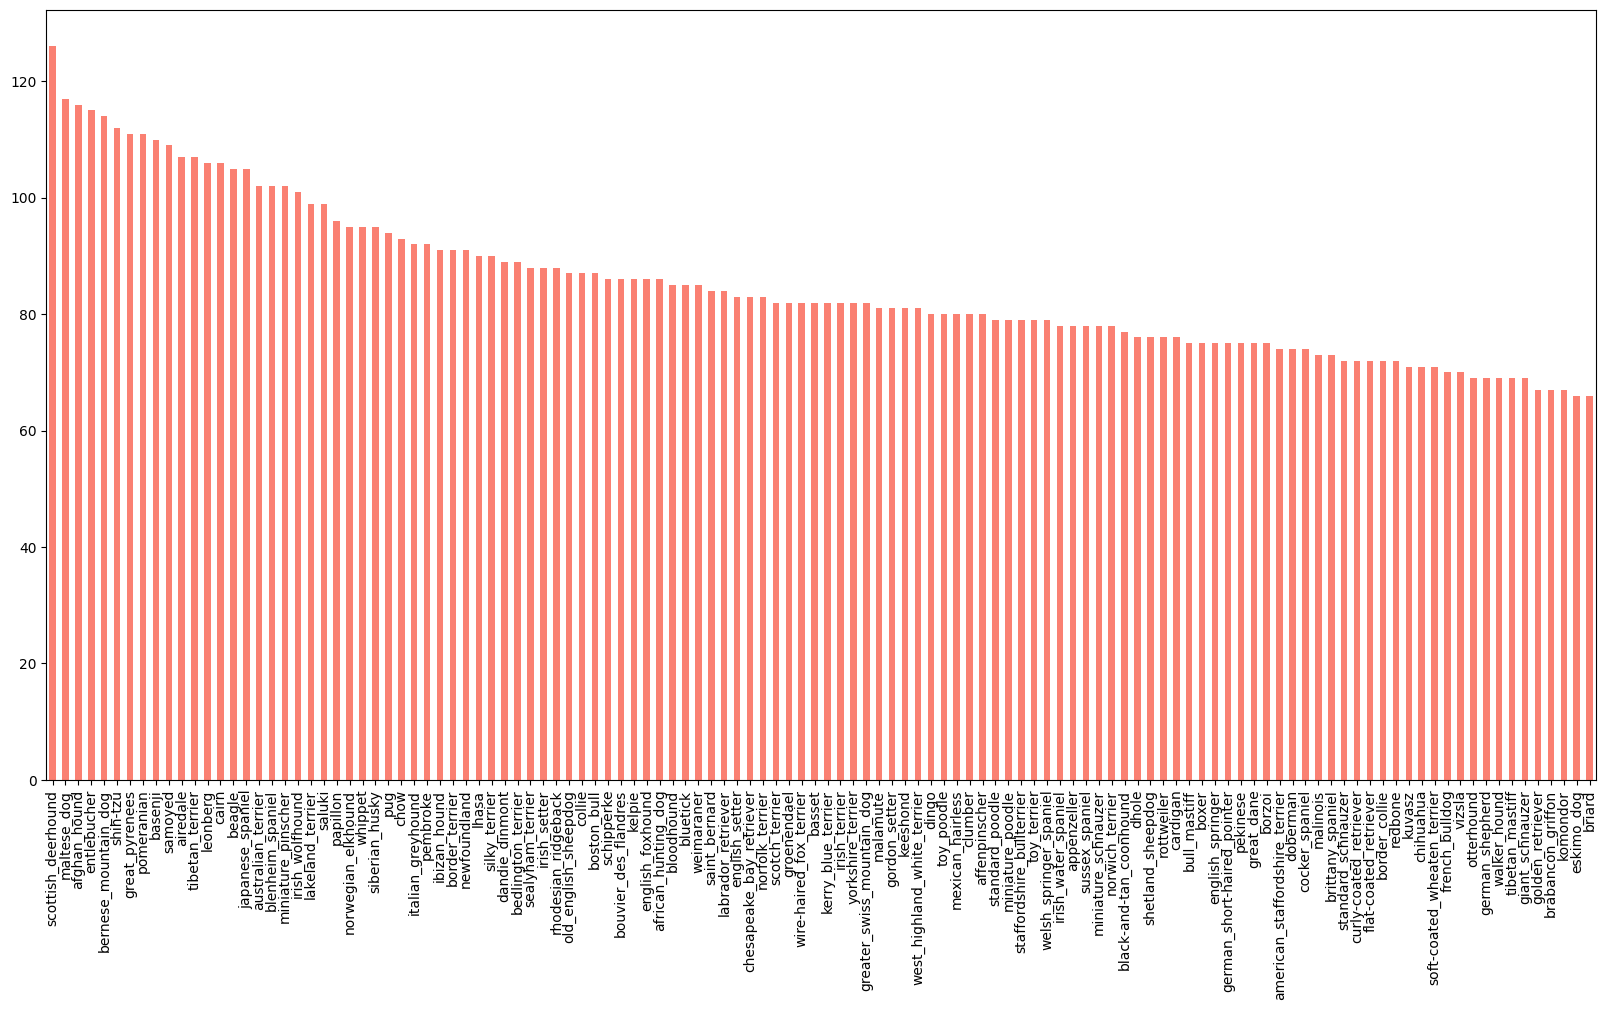

In [9]:
df["breed"].value_counts().plot.bar(figsize=(20, 10), color="salmon")

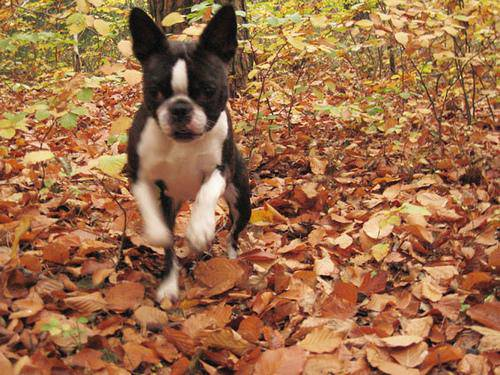

In [10]:
#Let's view an image
from IPython.display import Image
Image("./train/000bec180eb18c7604dcecc8fe0dba07.jpg")

## Getting Images and Their Labels

In [11]:
filenames = ["./train/" + fname for fname in df["id"] + ".jpg"]

In [12]:
len(filenames)

10222

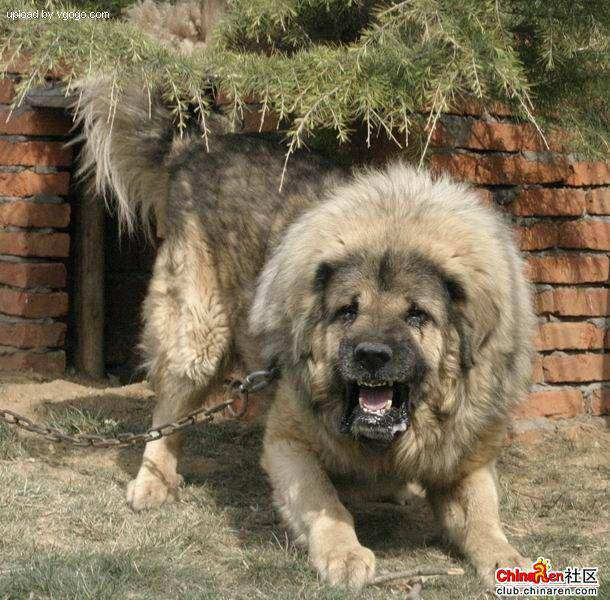

In [13]:
Image(filenames[9000])

In [14]:
df["breed"][9000]

'tibetan_mastiff'

In [15]:
import numpy as np 
labels = df['breed'].to_numpy()
len(labels)

10222

In [16]:
#Find the unique labels
unique_breed = np.unique(labels)
len(unique_breed)

120

In [17]:
#Turning every label into a boolean array
boolean_labels = [label == np.array(unique_breed) for label in labels]

In [18]:
len(boolean_labels)

10222

In [19]:
print(labels[0])
print(np.where(unique_breed == labels[0])[0][0])
print(boolean_labels[0].argmax())
print(unique_breed[boolean_labels[0].argmax()])
print(boolean_labels[0].astype("int"))

boston_bull
19
19
boston_bull
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Create Our Valid Set

In [20]:
#Set up X and y variables
X = filenames
y = boolean_labels

In [21]:
#Set the number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step: 1000}

In [22]:
#Let's Split Our data into train and valid set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES],
                                                  test_size=.2,
                                                  random_state=42)

In [23]:
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

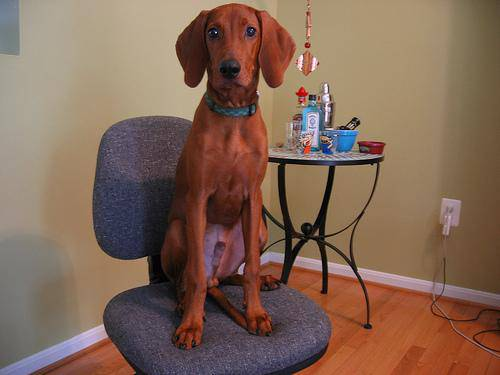

In [24]:
Image(X_train[69])

In [25]:
unique_breed[boolean_labels[69].argmax()]

'bloodhound'

## Preprocessing Images (turning images into Tensors)

In [26]:
#Define image size 
img_size = 224

#Create a function for preprocessing images
def process_image(img_path, img_size=img_size):
  #Read in an image file
  image = tf.io.read_file(img_path)
  #Turn the jpeg image into numerical Tensor with 3 color channels
  image = tf.image.decode_jpeg(image, channels=3)
  #Normalization (Rescale)
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Resize in a desired size
  image = tf.image.resize(image, size=[img_size, img_size])
  
  return image

## Turn our data into batches

In [27]:
#Create a simple function to return a tuple (image, label)
def get_image_label(img_path, label):
  image = process_image(img_path)
  
  return image, label

In [28]:
#Define the batch size 
batch_size = 32

#Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=batch_size, valid_data=False, test_data=False):
  #If the data is the test dataset, we probably dont have the labels
  if test_data:
    print("Creating testing data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  if valid_data:
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                tf.constant(y)))
    
    #Shuffling pathnames and labels before mapping image processor function
    # is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))
    data_batch = data.map(get_image_label).batch(batch_size)
    
  return data_batch

In [29]:
#Create training and validation batches
train_data = create_data_batches(X_train,y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating valid data batches...


In [30]:
#Checkout the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualize data batches

In [38]:
#Setup the figure
import matplotlib.pyplot as plt 
def show_random_images(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(unique_breed[labels[i].argmax()])
    plt.axis("off")

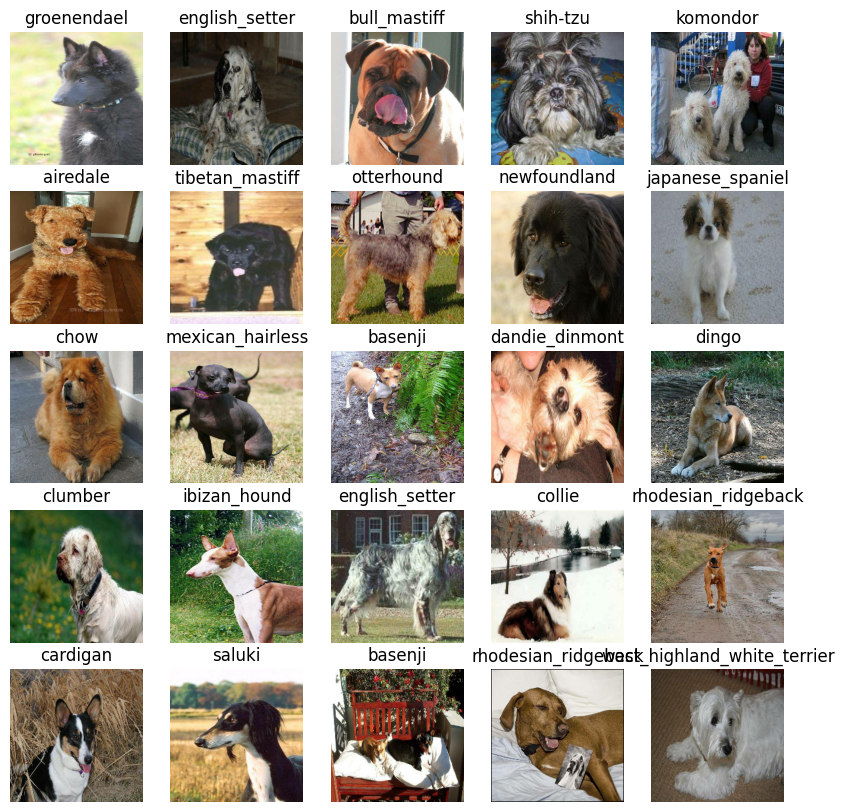

In [40]:
#Let's see some shits
train_images, train_labels = next(train_data.as_numpy_iterator())
show_random_images(train_images, train_labels)

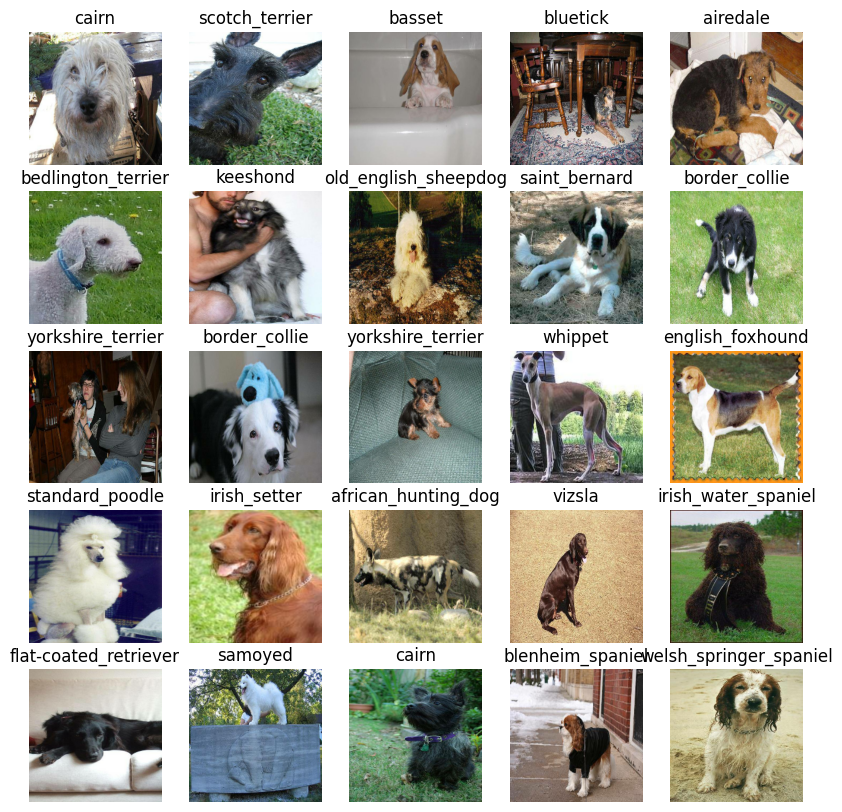

In [41]:
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_random_images(valid_images, valid_labels)

In [34]:
train_labels.astype("int")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Building a Model

In [42]:
#Setup input shape to the model
INPUT_SHAPE = [None, img_size, img_size, 3]

#Setup output shape
OUTPUT_SHAPE = len(unique_breed)

#Setup the model url from tfhub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [43]:
import tensorflow_hub as hub

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url),
    tf.keras.layers.Dense(units=output_shape,
                          activation="softmax")
  ])
  
  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics="accuracy"
  )
  
  model.build(input_shape)
  
  return model

In [44]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


Text(0.5, 1.0, 'groenendael')

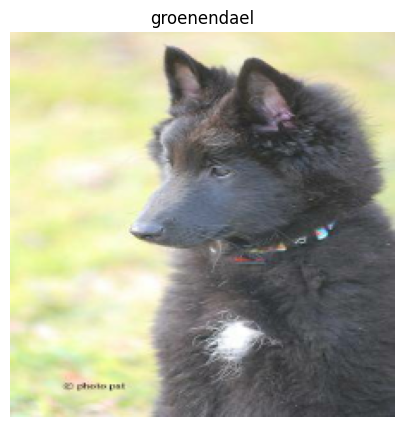

In [45]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(train_images[0])
ax.set_axis_off()
ax.set_title(unique_breed[train_labels[0].argmax()])

### TensorBoard Callback

In [47]:
#Load TensorBoard notebook extension
%load_ext tensorboard

In [52]:
import datetime
import os

#Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  #Create a log directory for storing TensorBoard logs
  logdir = os.path.join("./logs",
                        #Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping

In [49]:
#Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

### Training a model (on a subset of data)

In [46]:
NUM_EPOCHS = 100

In [50]:
def train_model():
  #Create a model
  model = create_model()
  
  #Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()
  
  #Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model

In [53]:
#Fit the model to the data
model = train_model()

Epoch 1/100
25/25 [==============================] - 33s 1s/step - loss: 4.5043 - accuracy: 0.1150 - val_loss: 3.4044 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 28s 1s/step - loss: 1.5870 - accuracy: 0.7212 - val_loss: 2.1595 - val_accuracy: 0.5200
Epoch 3/100
25/25 [==============================] - 30s 1s/step - loss: 0.5394 - accuracy: 0.9488 - val_loss: 1.6802 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 28s 1s/step - loss: 0.2452 - accuracy: 0.9837 - val_loss: 1.5009 - val_accuracy: 0.6550
Epoch 5/100
25/25 [==============================] - 24s 950ms/step - loss: 0.1417 - accuracy: 0.9950 - val_loss: 1.4239 - val_accuracy: 0.6700
Epoch 6/100
25/25 [==============================] - 23s 920ms/step - loss: 0.0985 - accuracy: 1.0000 - val_loss: 1.3753 - val_accuracy: 0.6650
Epoch 7/100
25/25 [==============================] - 24s 984ms/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 1.3418 - val_accuracy: 0.6700
Epoc

Look likes our model is overfitting

### Making and Evaluating predictions using a trained model

In [54]:
valid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [55]:
#Make predictions on the validation data
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 7s 887ms/step


array([[2.27606483e-03, 2.08688245e-04, 6.44538202e-04, ...,
        8.39297718e-04, 8.52892554e-05, 1.16465380e-02],
       [5.72941825e-03, 1.83411845e-04, 2.53903698e-02, ...,
        7.05738610e-04, 2.74355477e-03, 4.57133341e-04],
       [1.01354244e-05, 1.11923306e-04, 8.41774454e-06, ...,
        2.27728771e-04, 2.83580128e-04, 1.24797516e-03],
       ...,
       [3.02912413e-05, 4.86551435e-04, 5.59849606e-04, ...,
        1.56970287e-04, 9.61535727e-04, 1.78180053e-03],
       [5.21974545e-03, 4.43755795e-04, 3.87087232e-04, ...,
        2.69455457e-04, 1.84449062e-04, 1.13233319e-02],
       [2.99928815e-05, 9.71495174e-05, 8.49521603e-04, ...,
        2.69372365e-03, 6.92159869e-04, 1.39995391e-04]], dtype=float32)

In [56]:
predictions.shape

(200, 120)

In [58]:
predictions[0].argmax()

26

In [59]:
unique_breed[predictions[0].argmax()]

'cairn'

In [60]:
unique_breed[valid_labels[0].argmax()]

'cairn'

In [61]:
def get_pred_label(prediction_probabilities):
  return unique_breed[np.argmax(prediction_probabilities)]

In [62]:
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

In [63]:
#Create a function to unbatch a batch dataset
def unbatchify(data):
  images = []
  labels = []
  
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
    
  return images, labels

In [70]:
#Unbatchify the validation dataset
val_images, val_labels = unbatchify(valid_data)
len(val_images)

200

In [72]:
val_labels[0].argmax()

26

In [73]:
val_pred = get_pred_label(val_labels[69])
val_pred

'airedale'

In [75]:
predictions.shape

(200, 120)

In [76]:
def plot_pred(prediction_probabilities, images, labels, n=1):
  pred_prob, image, true_label = prediction_probabilities[n], images[n], labels[n]
  
  pred_label = get_pred_label(pred_prob)
  
  plt.imshow(image)
  plt.axis("off")
  
  if pred_label == unique_breed[true_label.argmax()]:
    color = 'green'
  else: color = 'red'
  
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob) * 100,
                                    unique_breed[np.argmax(true_label)]),
            color = color)

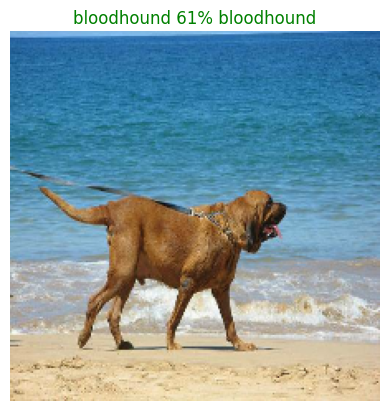

In [80]:
plot_pred(predictions, val_images, val_labels, 100)